In [23]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Direction Look-Up-Tables (LUTs)

**Datasample:** gamma-1 (goes into energy training)

**Data level:** DL1b (telescope-wise image parameters)

**Scope:**

To obtain an estimate for an image, given its intensity, width and length, how reliable its axis is as a measure of the shower axis' orientation.  
The values from the LUTs can be used to set relative weights for the different telescopes in the stereoscopic reconstruction of events with three or more valid images.

**Approach:**

- calculate for each image the miss parameter, aka the distance from the image axis to the point on the camera which corresponds to the true gamma-ray direction

- build a LUT per telescope type, containing in bins of image intensity and width/length, the square of \<miss>.

## Table of contents
- [Counts](#Counts-LUTs)
- [Counts ratio between protopipe and CTAMARS](#Count-LUTs-ratio-between-protopipe-and-CTAMARS)
- [Direction LUT](#Direction-LUT)
- [Direction LUT comparisons between protopipe and CTAMARS](#Direction-LUT-ratio-between-protopipe-and-CTAMARS)
  - [Profile along Y-axis (width/length)](#Profile-along-Y-axis-(width/length))
  - [Ratio between the LUTs](#Ratio-between-the-LUTs)

## Imports

In [24]:
from pathlib import Path

import numpy as np
from scipy.stats import binned_statistic_2d
import pandas
import tables
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from ctapipe.image import camera_to_shower_coordinates

## Functions

In [25]:
def get_camera_names(inputPath = None, fileName = None):
    """Read the names of the cameras.
    
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    camera_names : list(str)
        Table names as a list.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    h5file = tables.open_file(inputPath / fileName, mode='r')
    group = h5file.get_node("/")
    camera_names = [x.name for x in group._f_list_nodes()]
    h5file.close()
    return camera_names

In [26]:
def load_reset_infile_protopipe(inputPath = None, fileName = None, camera_names=None, cols=None):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type.
     
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    dataFrames : dict(pandas.DataFrame)
        Dictionary of tables per camera.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    if camera_names is None:
        print("ERROR: no cameras specified")
    # load DL1 images
    dataFrames = {camera : pandas.read_hdf(inputPath / fileName, f"/{camera}") for camera in camera_names}
    return dataFrames

## Input data

In [27]:
# First we check if a _plots_ folder exists already.
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)

### CTAMARS

In [28]:
indir_CTAMARS = Path("/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2019/CTAMARS_reference_data/TRAINING/DL1")
filename_CTAMARS = "DirLUT.root"
filepath_CTAMARS = Path(indir_CTAMARS, filename_CTAMARS)

CTAMARS_cameras = ["LSTCam", "NectarCam"]
CTAMARS_histograms = ["DirLookupTable", "DirLookupTable_degrees", "DirEventStatistics"]

CTAMARS = dict.fromkeys(CTAMARS_cameras)

with uproot.open(filepath_CTAMARS) as infile_CTAMARS:
    
    for camera_index in range(len(CTAMARS_cameras)):
        
        CTAMARS[CTAMARS_cameras[camera_index]] = dict.fromkeys(CTAMARS_histograms)
        
        CTAMARS[CTAMARS_cameras[camera_index]][f"DirLookupTable"] = infile_CTAMARS[f"DirLookupTable_type{camera_index}"]
        CTAMARS[CTAMARS_cameras[camera_index]][f"DirLookupTable_degrees"] = infile_CTAMARS[f"DirLookupTable_degrees_type{camera_index}"]
        CTAMARS[CTAMARS_cameras[camera_index]][f"DirEventStatistics"] = infile_CTAMARS[f"DirEventStatistics_type{camera_index}"]
        
CTAMARS_X_edges = CTAMARS["LSTCam"]["DirLookupTable"].axes[0].edges()
CTAMARS_Y_edges = CTAMARS["LSTCam"]["DirLookupTable"].axes[1].edges()

### protopipe

In [29]:
# EDIT ONLY THIS CELL
indir_protopipe = Path("/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.4.0_dev1/data/TRAINING/for_energy_estimation")
filename_protopipe = "TRAINING_energy_tail_gamma_merged.h5"

In [30]:
cameras = get_camera_names(inputPath = indir_protopipe,
                           fileName = filename_protopipe)

PROTOPIPE = load_reset_infile_protopipe(inputPath = indir_protopipe,
                                        fileName = filename_protopipe,
                                        camera_names=cameras)

- ``miss`` is here defined as the absolute value of the component transverse to the main shower axis of the distance between the true source position (0,0 in case of on-axis simulation) and the COG of the cleaned image,
- it is calculated for ALL images of the gamma1 sample and added to the tables for each camera,
- then we select only images for which miss < 1.0 deg in each camera

In [31]:
PROTOPIPE_selected = {}

for camera in cameras:
    
    hillas_x = PROTOPIPE[camera]["hillas_x_reco"]
    hillas_y = PROTOPIPE[camera]["hillas_y_reco"]
    hillas_psi = PROTOPIPE[camera]["hillas_psi_reco"]
    
    # Components of the distance between center of the camera (for on-axis simulations) and reconstructed position of the image
    longitudinal, transverse = camera_to_shower_coordinates(x     = 0.,
                                                            y     = 0., 
                                                            cog_x = hillas_x, 
                                                            cog_y = hillas_y, 
                                                            psi   = np.deg2rad(hillas_psi))
    
    # Take the absolute value of the transverse component
    # Add miss to the dataframe
    PROTOPIPE[camera]["miss"] = np.abs(transverse)
    
    # miss < 1 deg
    mask = PROTOPIPE[camera]["miss"] < 1.0
    
    # Make a smaller dataframe with just what we actually need and select for miss < 1 deg
    PROTOPIPE_selected[camera] = PROTOPIPE[camera][['hillas_intensity_reco', 'hillas_width_reco', 'hillas_length_reco', 'miss']].copy()
    PROTOPIPE_selected[camera] = PROTOPIPE_selected[camera][mask]

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Counts
[back to top](#Table-of-contents)

This is just the 2D grid that will host the LUT, showing how many events fall in each bin.

In CTAMARS an additional image quality cut for direction reconstruction selects for images that fall in a bin which contains >10 images

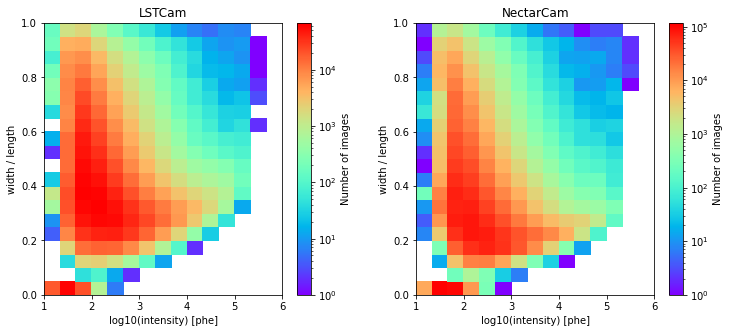

In [32]:
fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace = 0.25)

PROTOPIPE_COUNTS = {}

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)
    
    intensity = PROTOPIPE_selected[camera]["hillas_intensity_reco"]
    width     = PROTOPIPE_selected[camera]["hillas_width_reco"]
    length    = PROTOPIPE_selected[camera]["hillas_length_reco"]

    PROTOPIPE_COUNTS[camera], _, _, _ = plt.hist2d(x = np.log10(intensity),
                                                   y = width / length,
                                                   bins = [CTAMARS_X_edges, CTAMARS_Y_edges],
                                                   norm = LogNorm(),
                                                   cmap = "rainbow")
    
    plt.title(camera)
    cb = plt.colorbar()
    cb.set_label("Number of images")
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("width / length")

## Counts ratio between protopipe and CTAMARS
[back to top](#Table-of-contents)

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


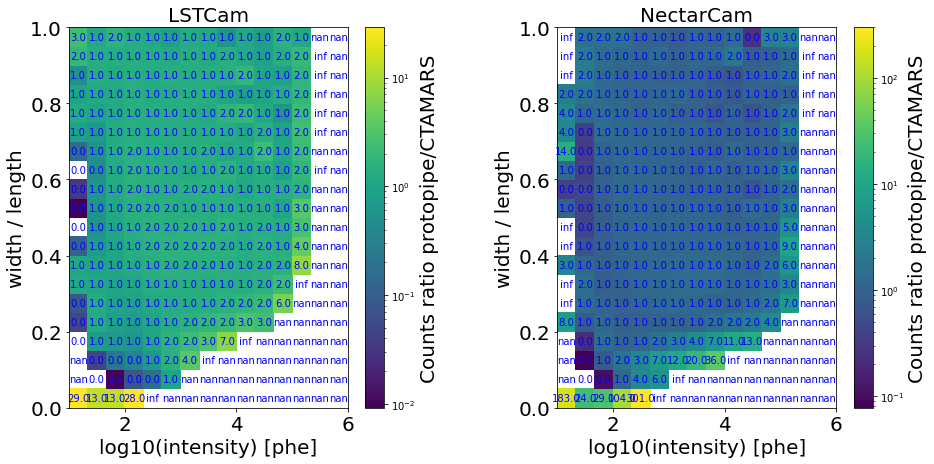

In [33]:
fig = plt.figure(figsize=(15, 7))
plt.subplots_adjust(wspace = 0.4)
font_size = 20

for i, camera in enumerate(cameras):
    
    RATIO = PROTOPIPE_COUNTS[camera]/CTAMARS[camera]["DirEventStatistics"].values()
    
    plt.subplot(1, 2, i+1)
    
    plt.pcolormesh(CTAMARS_X_edges,
                   CTAMARS_Y_edges,
                   np.transpose(PROTOPIPE_COUNTS[camera]/CTAMARS[camera]["DirEventStatistics"].values()),
                   norm = LogNorm()
                   )
    
    # add value labels for better visualization
    for i, x in enumerate(CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers()):
        for j, y in enumerate(CTAMARS[camera]["DirLookupTable_degrees"].axes[1].centers()):
            plt.text(x,
                     y,
                     np.round(RATIO[i][j]),
                     ha='center',va='center',
                     size=10,color='b')
    
    plt.title(camera, fontsize=font_size)
    ax = plt.gca()
    cb = plt.colorbar()
    cb.set_label("Counts ratio protopipe/CTAMARS", fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='both', which='minor', labelsize=font_size)
    plt.xlabel("log10(intensity) [phe]", fontsize=font_size)
    plt.ylabel("width / length", fontsize=font_size)

## Direction LUT
[back to top](#Table-of-contents)

In [34]:
# Build the LUT by using,

#    - ``np.log10(intensity)`` as ``x`` axis,
#    - ``width/length`` as ``y``axis,

# For each 2D bin we calculate the ``mean of miss`` for the images which fall into that bin.

mean_miss = {}

for camera in cameras:
    
    intensity = PROTOPIPE_selected[camera]["hillas_intensity_reco"]
    width     = PROTOPIPE_selected[camera]["hillas_width_reco"]
    length    = PROTOPIPE_selected[camera]["hillas_length_reco"]
    miss      = PROTOPIPE_selected[camera]["miss"]
    
    mean_miss[camera], _, _, _ = binned_statistic_2d(x = np.log10(intensity), 
                                                     y = width/length, 
                                                     values = miss, 
                                                     statistic='mean', 
                                                     bins=[CTAMARS_X_edges, CTAMARS_Y_edges]
                                                    )

In [35]:
# After obtaining such a 2D binned statistic we square the value of each bin.
# That is the final LUT

LUT = {}

for camera in cameras:
    
    LUT[camera] = np.square(mean_miss[camera])

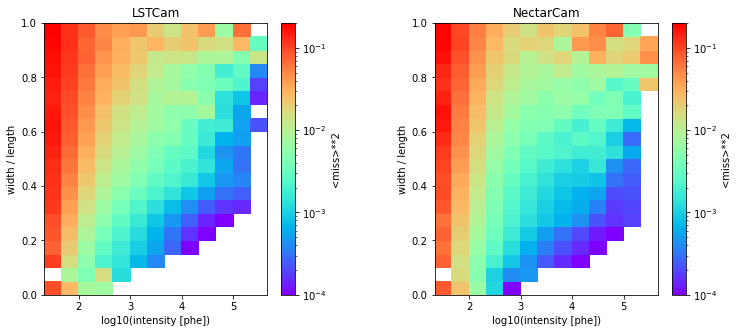

In [36]:
fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace = 0.4)

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)
    
    plt.pcolormesh(CTAMARS_X_edges,
                   CTAMARS_Y_edges,
                   np.transpose( LUT[camera] ),
                   norm = LogNorm(vmin = 1.e-4, vmax = 2.e-1),
                   cmap = "rainbow"
                  )
    
    plt.title(camera)
    cb = plt.colorbar()
    cb.set_label("<miss>**2")
    plt.xlabel("log10(intensity [phe])")
    plt.ylabel("width / length")
    plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-2])

## Direction LUT comparisons between protopipe and CTAMARS
[back to top](#Table-of-contents)

### Profile along Y-axis (width/length)
[back to top](#Table-of-contents)

Here we select as an example the bin #9, containing images with 0.45 < width / length < 0.55

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


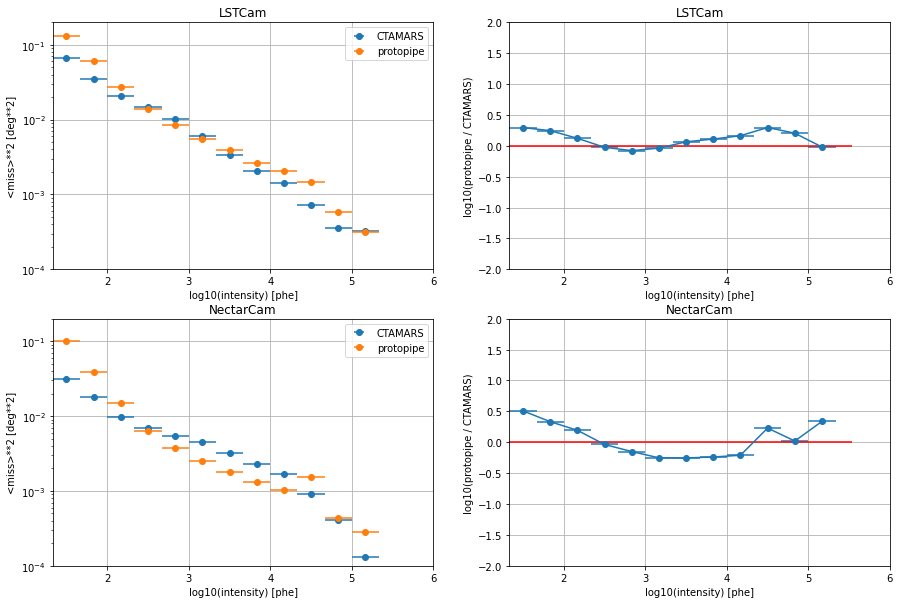

In [37]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

for i, camera in enumerate(cameras):
    
    plt.subplot(2, 2, i*2+1)
    
    H = np.transpose(CTAMARS[camera]["DirLookupTable_degrees"].values())
    
    plt.errorbar(x = CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers(),
                 y = H[9],
                 xerr = np.diff(CTAMARS_X_edges)/2,
                 yerr = None,
                 fmt="o",
                 label="CTAMARS")
    
    plt.errorbar(x = CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers(),
                 y = np.transpose(LUT[camera])[9],
                 xerr = np.diff(CTAMARS_X_edges)/2,
                 yerr = None,
                 fmt="o",
                 label="protopipe")
    
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("<miss>**2 [deg**2]")
    plt.grid()
    plt.yscale("log")
    plt.title(camera)
    plt.legend()
    plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-1])
    plt.ylim(1.e-4, 2.e-1)
    
    plt.subplot(2, 2, i*2+2)
    
    ratio = np.transpose(LUT[camera])[9] / H[9]
    plt.errorbar(x = CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers()[1:-1],
                 y = np.log10(ratio[1:-1]),
                 xerr = np.diff(CTAMARS_X_edges[1:-1])/2,
                 yerr = None,
                 ls = "-",
                 fmt="o",)
    plt.hlines(0., plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], colors="red", linestyles='solid')
    
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("log10(protopipe / CTAMARS)")
    plt.grid()
    plt.title(camera)
    plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-1])
    plt.ylim(-2,2.)

### Ratio between the LUTs
[back to top](#Table-of-contents)

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


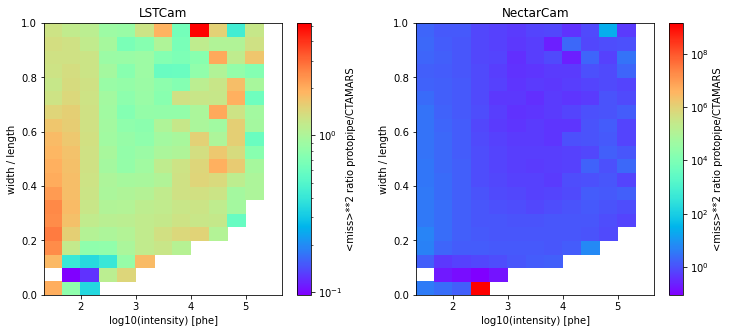

In [38]:
# we use the same bin edges of CTAMARS reference data

fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace = 0.25)

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)
    
    plt.pcolormesh(CTAMARS_X_edges,
                   CTAMARS_Y_edges,
                   np.transpose( LUT[camera] / CTAMARS[camera]["DirLookupTable_degrees"].values()),
                   norm=LogNorm(),
                   cmap = "rainbow"
                   )
    
    plt.title(camera)
    cb = plt.colorbar()
    cb.set_label("<miss>**2 ratio protopipe/CTAMARS")
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("width / length")
    plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-2])

Same, but zomming in the regime of current image quality cuts

- 0.1 < width/length < 0.6
- intensity > 50 phe

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


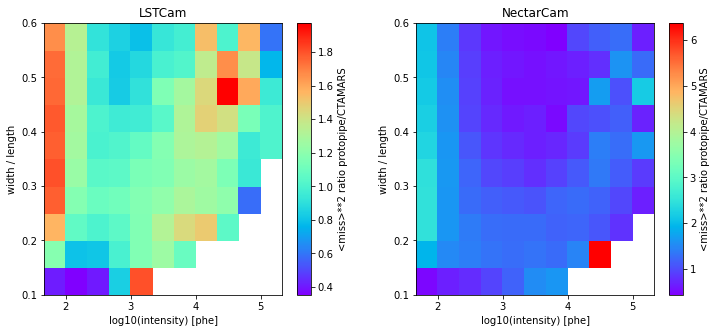

In [39]:
fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace = 0.25)

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)
    
    plt.pcolormesh(CTAMARS_X_edges[2:-2],
                   CTAMARS_Y_edges[2:13],
                   np.transpose( LUT[camera] / CTAMARS[camera]["DirLookupTable_degrees"].values())[2:12,2:-2],
                   cmap = "rainbow"
                   )
    
    plt.title(camera)
    cb = plt.colorbar()
    cb.set_label("<miss>**2 ratio protopipe/CTAMARS")
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("width / length")